## Coding Attention Mechanisms

Packages that are being used in this notebook:

In [2]:
from importlib.metadata import version

print("torch version:", version("torch"))

torch version: 2.10.0


* This chapter covers attention mechanisms, the engine of LLMs:

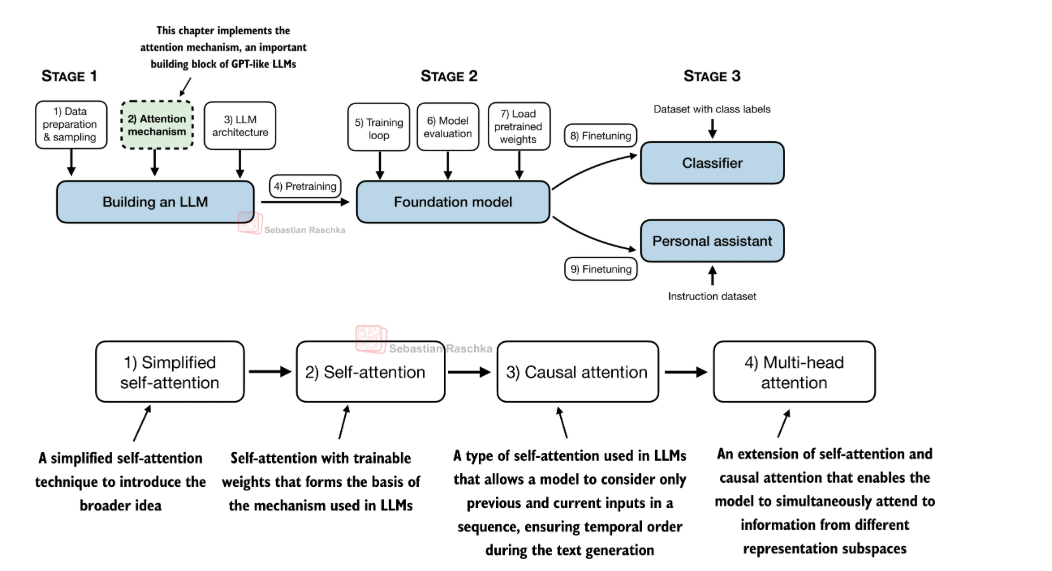

## The problem with modeling long sequences

* No code in this section
* Translating a text word by word is not feasible due to the differences in grammatical structures between the source and target languages:

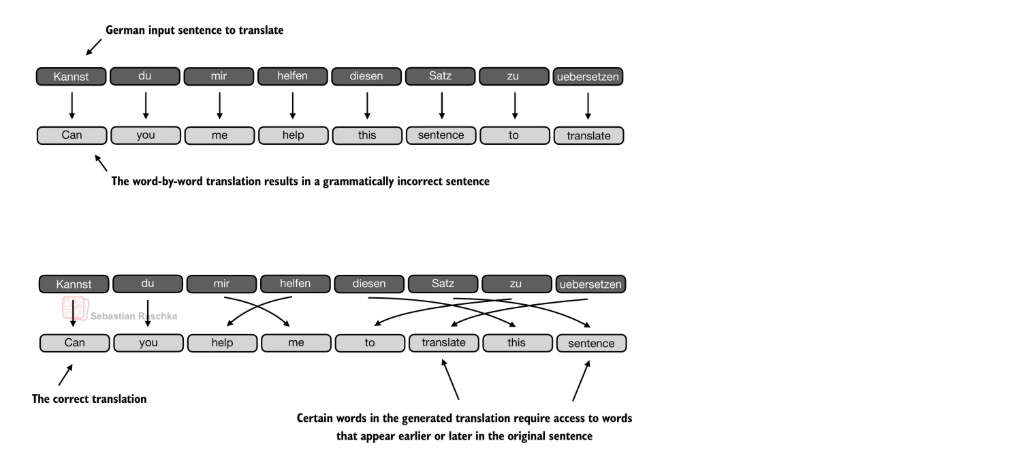

* Prior to the introduction of transformer models, encoder-decoder RNNs were commonly used for machine translation tasks
* In this setup, the encoder processes a sequence of tokens from the source language, using a hidden state—a kind of intermediate layer within the neural network—to generate a condensed representation of the entire input sequence:

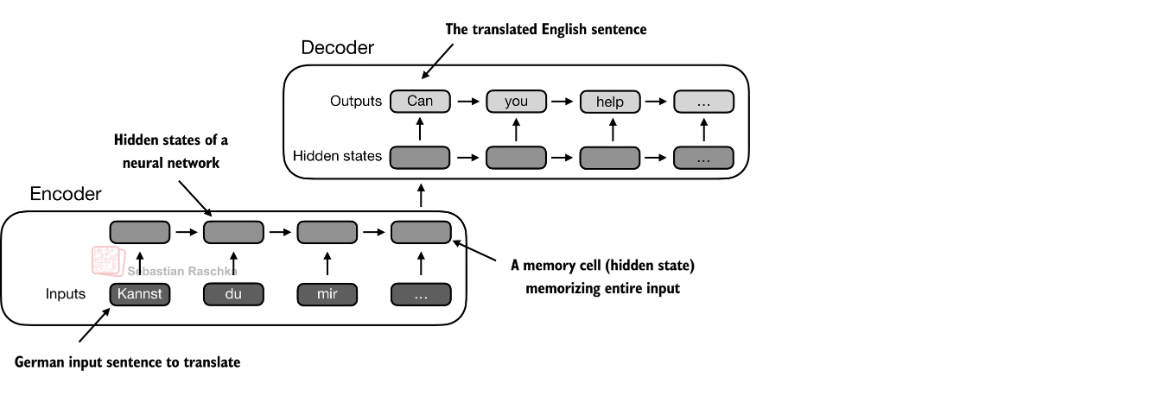

### Capturing data dependencies with attention mechanisms

* No code in this section
* Through an attention mechanism, the text-generating decoder segment of the network is capable of selectively accessing all input tokens, implying that certain input tokens hold more significance than others in the generation of a specific output token:

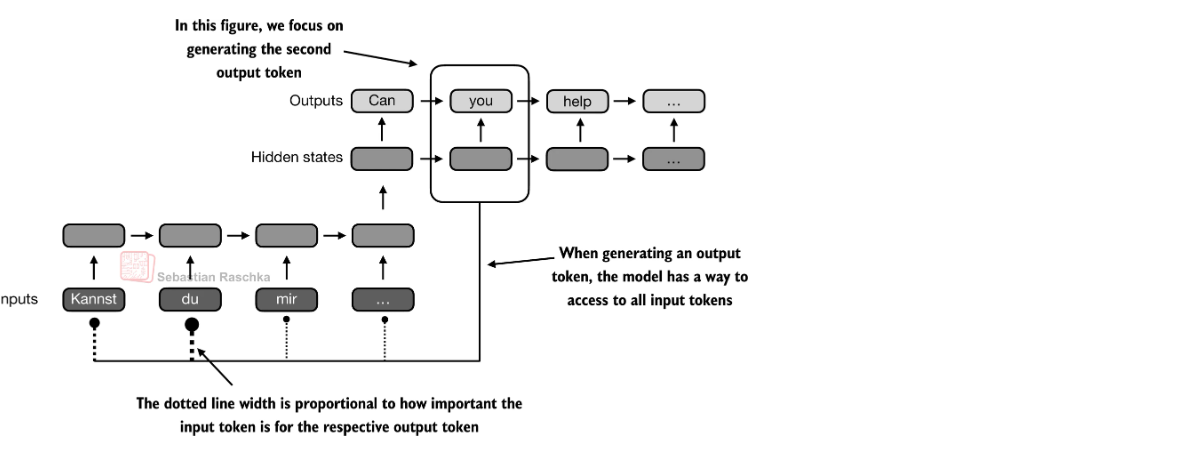

* Self-attention in transformers is a technique designed to enhance input representations by enabling each position in a sequence to engage with and determine the relevance of every other position within the same sequence

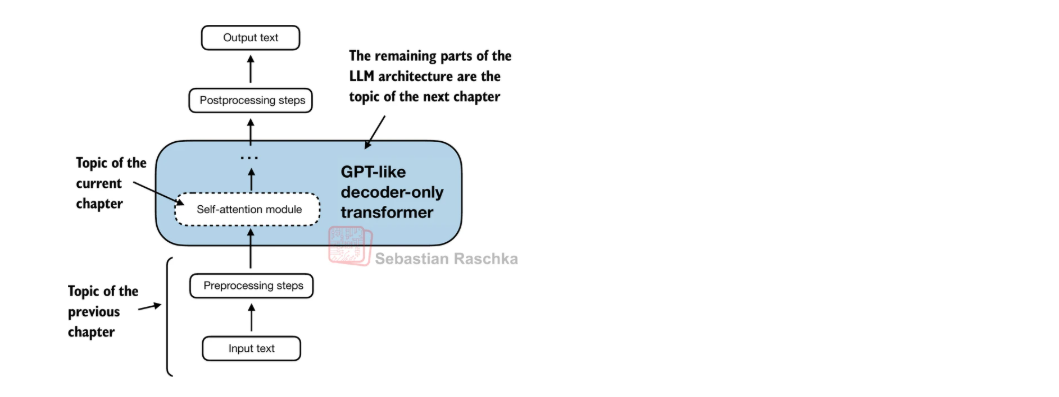

* This chapter covers attention mechanisms, the engine of LLMs:

In [2]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

d:\LLMs-from-scratch\.venv\lib\site-packages\torch\_subclasses\functional_tensor.py:283: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


In [3]:
query = inputs[1]  # 2nd input token is the query
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


* (In this book, we follow the common machine learning and deep learning convention where training examples are represented as rows and feature values as columns; in the case of the tensor shown above, each row represents a word, and each column represents an embedding dimension)

* The primary objective of this section is to demonstrate how the context vector 
 is calculated using the second input sequence, 
, as a query

* The figure depicts the initial step in this process, which involves calculating the attention scores ω between 
 and all other input elements through a dot product operation

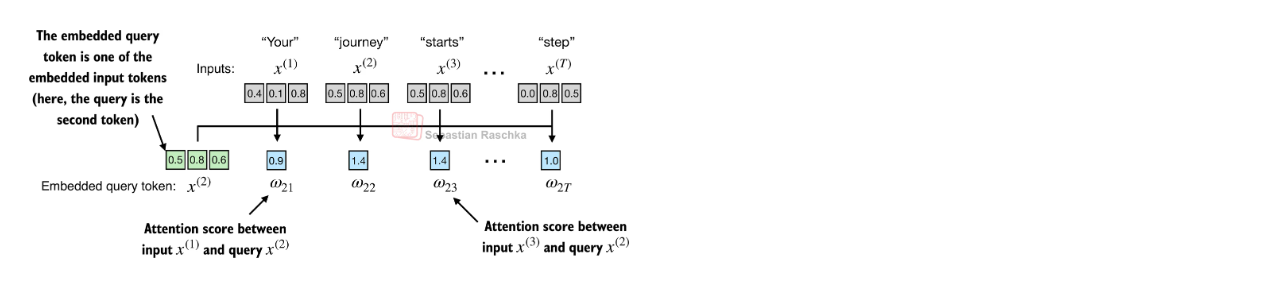

* We use input sequence element 2, 
, as an example to compute context vector 
; later in this section, we will generalize this to compute all context vectors.
* The first step is to compute the unnormalized attention scores by computing the dot product between the query 
 and all other input tokens:

* Side note: a dot product is essentially a shorthand for multiplying two vectors elements-wise and summing the resulting products:

In [4]:
res = 0.

for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]

print(res)
print(torch.dot(inputs[0], query))

tensor(0.9544)
tensor(0.9544)


* Step 2: normalize the unnormalized attention scores ("omegas", 
) so that they sum up to 1
* Here is a simple way to normalize the unnormalized attention scores to sum up to 1 (a convention, useful for interpretation, and important for training stability):

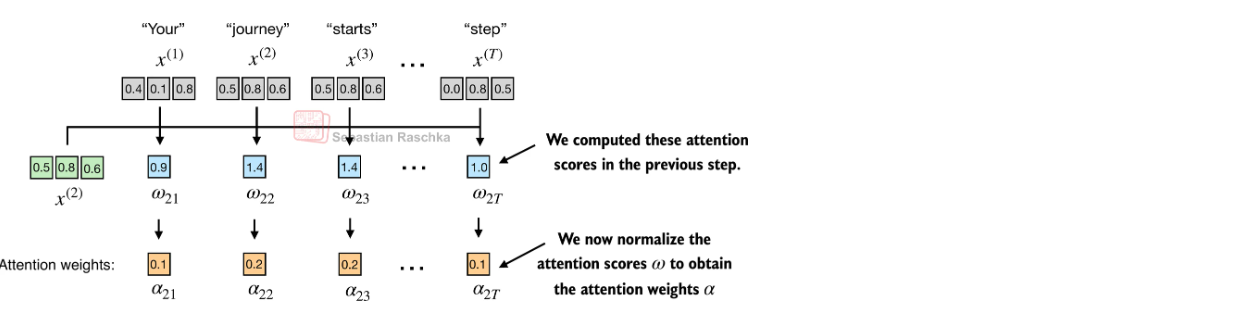

In [8]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


* However, in practice, using the softmax function for normalization, which is better at handling extreme values and has more desirable gradient properties during training, is common and recommended.
* Here's a naive implementation of a softmax function for scaling, which also normalizes the vector elements such that they sum up to 1:

In [9]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


* The naive implementation above can suffer from numerical instability issues for large or small input values due to overflow and underflow issues
* Hence, in practice, it's recommended to use the PyTorch implementation of softmax instead, which has been highly optimized for performance:

In [6]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


### Step 3: compute the context vector 
 by multiplying the embedded input tokens, 
 with the attention weights and sum the resulting vectors:

* Step 3: compute the context vector 
 by multiplying the embedded input tokens, 
 with the attention weights and sum the resulting vectors

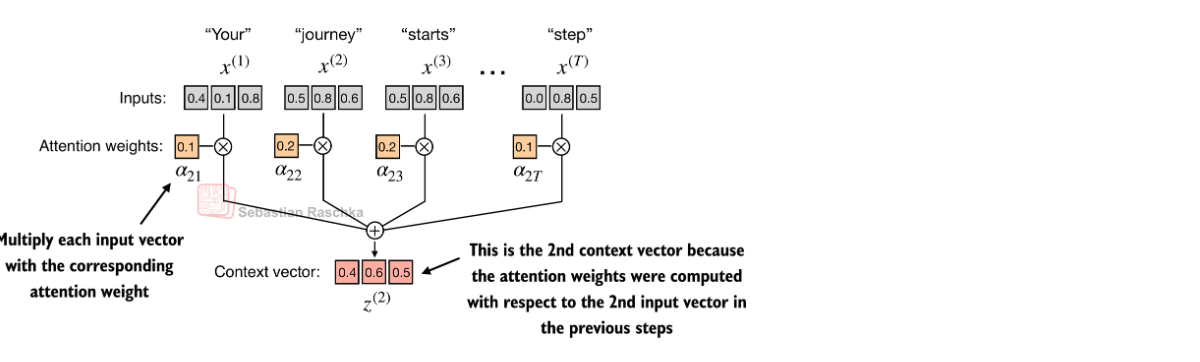

In [7]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


### Computing attention weights for all input tokens

* Generalize to all input sequence tokens:
- Above, we computed the attention weights and context vector for input 2 (as illustrated in the highlighted row in the figure below)
- Next, we are generalizing this computation to compute all attention weights and context vectors

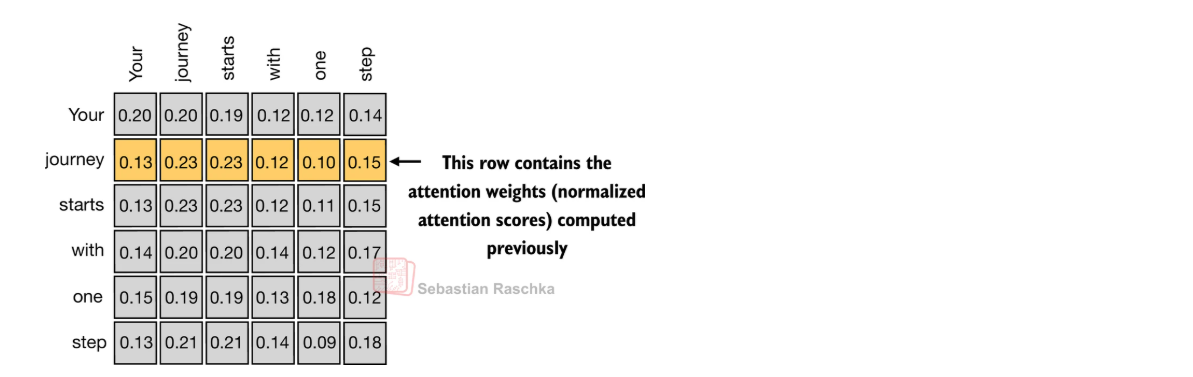

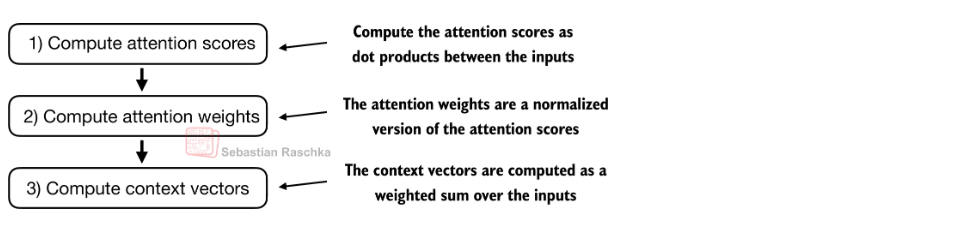

* Apply previous `step 1` to all pairwise elements to compute the unnormalized attention score matrix:

In [8]:
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


* We can achieve the same as above more efficiently via matrix multiplication:

In [9]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


* Similar to step 2 previously, we normalize each row so that the values in each row sum to 1:

In [10]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


* Quick verification that the values in each row indeed sum to 1:

In [11]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)

print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


* Apply previous step 3 to compute all context vectors

In [12]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


* As a sanity check, the previously computed context vector       [0.4419, 0.6515, 0.5683] 
 can be found in the 2nd row in above:

In [13]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


* Implementing self-attention with trainable weights

* A conceptual framework illustrating how the self-attention mechanism developed in this section integrates into the overall narrative and structure of this book and chapter

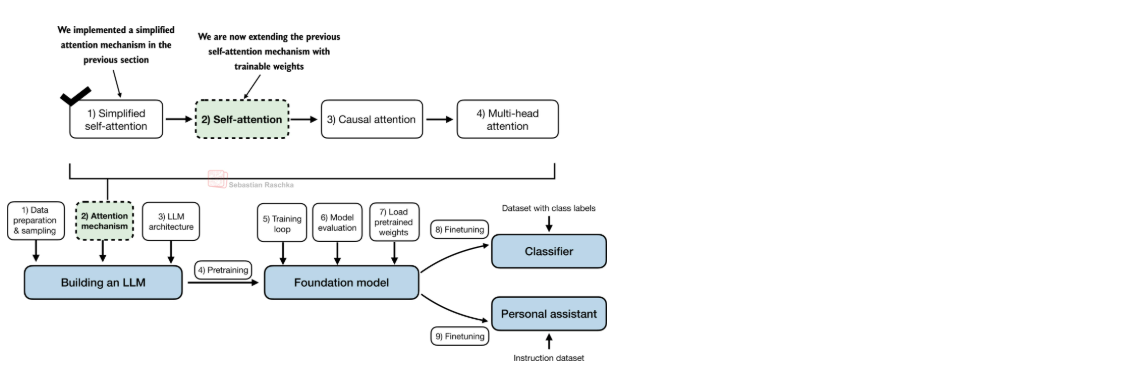